In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import seaborn as sns
from sklearn.manifold import TSNE
import os
try:
    os.mkdir('figures')
except FileExistsError:
    pass

import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')
from ccmf import CCMF, CircuitEditor, UniformModel, load_fake_dm9

np.random.seed(10)
torch.manual_seed(10)

In [2]:
notebook_name = 'linear_no_noise'

# Load circuit

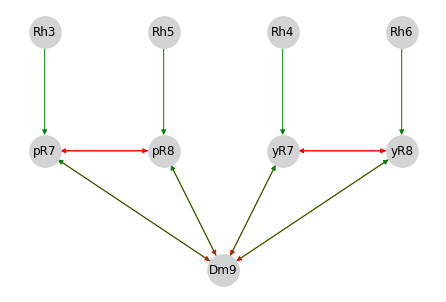

In [3]:
circuit = pickle.load(open('circuits/Dm9.circuit', 'rb'))
circuit.show()

# Load data

In [4]:
W, M, U, X = load_fake_dm9()
X

stimulus,300.000000,327.777778,355.555556,383.333333,411.111111,438.888889,466.666667,494.444444,522.222222,550.000000
cell,,,,,,,,,,
Rh3,0.606531,0.905955,0.993846,0.800737,0.473827,0.205924,0.065729,0.015408,0.002653,0.000335
Rh4,0.135335,0.352322,0.673638,0.945959,0.975611,0.738991,0.411112,0.167973,0.050406,0.011109
Rh5,0.011109,0.050406,0.167973,0.411112,0.738991,0.975611,0.945959,0.673638,0.352322,0.135335
Rh6,0.000335,0.002653,0.015408,0.065729,0.205924,0.473827,0.800737,0.993846,0.905955,0.606531
pR7,0.792459,1.161199,1.194870,0.762329,0.079556,-0.473936,-0.670218,-0.556945,-0.332050,-0.150686
yR7,0.171381,0.454857,0.869636,1.186215,1.103980,0.571343,-0.112891,-0.566997,-0.637469,-0.450452
pR8,-0.398385,-0.549900,-0.456876,-0.016921,0.609885,1.065438,1.090244,0.759515,0.367288,0.119314
yR8,-0.098619,-0.244481,-0.446824,-0.574247,-0.435394,0.041014,0.666359,1.084749,1.073630,0.740392
Dm9,-0.026529,-0.039411,-0.054828,-0.093737,-0.178657,-0.294283,-0.381648,-0.385191,-0.302119,-0.182729


# Fitting (MAP estimation)

In [5]:
ccmf = CCMF(UniformModel(circuit), sigma_u=1, sigma_x=1, max_iter=2000)
ccmf.fit(X)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:23<00:00, 86.59it/s]


CCMF(guide=None, kernel=None, loss=None, model=None, optimizer=None)

Text(0, 0.5, 'Loss')

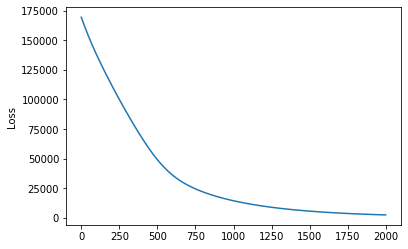

In [6]:
plt.figure()
plt.plot(ccmf.loss_curve)
plt.ylabel('Loss')

# Run MCMC

In [ ]:
ccmf.run_mcmc(X)

Sample:  13%|█████▍                                    | 13/100 [00:58,  6.72s/it, step size=3.91e-03, acc. prob=0.867]

In [ ]:
EX = lambda W, M, U: torch.cat([U, UniformModel.EV(W, M, U)])
data = dict(W=W, M=M, U=U, X=X)
for i in ['U', 'X']:
    data[i].columns = pd.Index(data['X'].columns.values.astype(int), name=data['X'].columns.name)
map_ = ccmf.map_estimates.copy()
mean = ccmf.sample_mean.copy()
mean['X'] = EX(mean['W'], mean['M'], mean['U'])
map_['X'] = EX(map_['W'], map_['M'], map_['U'])

# Comparing data, MAP, and sample mean
## Feedforward weights

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'W'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Recurrent weights

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'M'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Latent inputs

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'U'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Responses

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'X'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Graphical posterior predictive checking

In [ ]:
samples = ccmf.get_samples()
post_samples = np.array(torch.stack([EX(Wi, Mi, Ui).flatten() for Wi, Mi, Ui in zip(samples['W'], samples['M'], samples['U'])]))
concat = np.concatenate([data['X'].values.reshape(1, data['X'].shape[0] * data['X'].shape[1]), post_samples])
embedding = TSNE(n_components=2)
y = embedding.fit_transform(concat)
labels = np.array([0] + [1] * len(post_samples))

plt.figure(figsize=(6, 6))
plt.scatter(*y[labels==0].T, label='Data', c='C4')
plt.scatter(*y[labels==1].T, label='Posterior', c='C8')
plt.legend()
plt.title('TSNE')
plt.savefig(f'figures/{notebook_name}_tsne.svg', format='svg')